# TP DEEP LEARNING 1

### Import des librairies

In [2]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
IMAGE_SIZE = 72

Using TensorFlow backend.


### Génération des figures

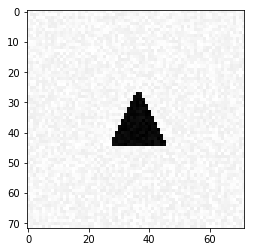

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Génération des données

In [3]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


## Modèle linéaire

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
nb_neurons = 3 # On choisit de réaliser un réseau avec 3 neurones sur chaque couche

In [9]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(Y_train, 3) # 3 classes d'output différente

### SGD optimisation

In [7]:
model = Sequential() # création du réseau de neurone
model.add(Dense(nb_neurons, input_shape=(5184,))) # première couche du réseau de neurone, qui reçoit 72*72 pixels
model.add(Dense(nb_neurons)) # seconde couche du réseau de neurone
model.add(Dense(3,activation='softmax')) # output du réseau, avec une activation softmax (pour un problème de classification)
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False) # méthode d'optimisation
model.compile(loss='categorical_crossentropy',optimizer=sgd)
model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 1.0935
Epoch 2/30
300/300 [==============================] - 0s 165us/step - loss: 1.0658
Epoch 3/30
300/300 [==============================] - 0s 165us/step - loss: 1.0463
Epoch 4/30
300/300 [==============================] - 0s 138us/step - loss: 1.0288
Epoch 5/30
300/300 [==============================] - 0s 175us/step - loss: 1.0133
Epoch 6/30
300/300 [==============================] - 0s 160us/step - loss: 1.0006
Epoch 7/30
300/300 [==============================] - 0s 130us/step - loss: 0.9860
Epoch 8/30
300/300 [==============================] - 0s 141us/step - loss: 0.9669
Epoch 9/30
300/300 [==============================] - 0s 161us/step - loss: 0.9596
Epoch 10/30
300/300 [==============================] - 0s 156us/step - loss: 0.9529
Epoch 11/30
300/300 [==============================] - 0s 158us/step - loss: 0.9347
Epoch 12/30
300/300 [==============================] - 0s 143us/step - loss: 0.9252
Epo

In [8]:
# Testing accuracy on disks
X_test_disk = np.array([generate_a_disk() for i in range(100)])
results = np.array(model.predict(X_test_disk))
good_answer = 0
for line in results:
    if line[1] == max(line):
        good_answer+=1
print("Accuracy on disks: {}".format(good_answer/len(results)))

# Testing accuracy on rectangles
X_test_rect = np.array([generate_a_rectangle() for i in range(100)])
results = np.array(model.predict(X_test_rect))
good_answer = 0
for line in results:
    if line[0] == max(line):
        good_answer+=1
print("Accuracy on rectangles: {}".format(good_answer/len(results)))

# Testing accuracy on triangles
X_test_tri = np.array([generate_a_triangle()[0] for i in range(100)])
results = np.array(model.predict(X_test_tri))
good_answer = 0
for line in results:
    if line[2] == max(line):
        good_answer+=1
print("Accuracy on triangles: {}".format(good_answer/len(results)))

Accuracy on disks: 0.92
Accuracy on rectangles: 0.36
Accuracy on triangles: 1.0


### Adam optimisation

In [9]:
model_2 = keras.models.Sequential([Dense(nb_neurons, input_shape=(5184,)),Dense(nb_neurons), Dense(3,activation='softmax')])
Adam_=Adam(lr=0.001)
model_2.compile(loss='categorical_crossentropy',optimizer=Adam_)
model_2.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 1.6978
Epoch 2/30
300/300 [==============================] - 0s 273us/step - loss: 1.0899
Epoch 3/30
300/300 [==============================] - 0s 268us/step - loss: 0.8311
Epoch 4/30
300/300 [==============================] - 0s 255us/step - loss: 0.7748
Epoch 5/30
300/300 [==============================] - 0s 256us/step - loss: 0.6937
Epoch 6/30
300/300 [==============================] - 0s 241us/step - loss: 0.6375
Epoch 7/30
300/300 [==============================] - 0s 225us/step - loss: 0.5726
Epoch 8/30
300/300 [==============================] - 0s 281us/step - loss: 0.5223
Epoch 9/30
300/300 [==============================] - 0s 198us/step - loss: 0.4745
Epoch 10/30
300/300 [==============================] - 0s 221us/step - loss: 0.4228
Epoch 11/30
300/300 [==============================] - 0s 198us/step - loss: 0.3839
Epoch 12/30
300/300 [==============================] - 0s 223us/step - loss: 0.3972
Epo

In [10]:
# Testing accuracy on disks
results = np.array(model_2.predict(X_test_disk))
good_answer = 0
for line in results:
    if line[1] == max(line):
        good_answer+=1
print("Accuracy on disks: {}".format(good_answer/len(results)))

# Testing accuracy on rectangles
results = np.array(model_2.predict(X_test_rect))
good_answer = 0
for line in results:
    if line[0] == max(line):
        good_answer+=1
print("Accuracy on rectangles: {}".format(good_answer/len(results)))

# Testing accuracy on triangles
results = np.array(model_2.predict(X_test_tri))
good_answer = 0
for line in results:
    if line[2] == max(line):
        good_answer+=1
print("Accuracy on triangles: {}".format(good_answer/len(results)))

Accuracy on disks: 0.89
Accuracy on rectangles: 1.0
Accuracy on triangles: 1.0


## Visualization

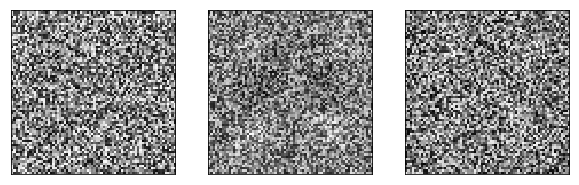

In [11]:
# for sgd
fig, a = plt.subplots(1,3,figsize=(10,6))
for i in range(3):
    a[i].imshow(model.get_weights()[0].T[i].reshape(72,72),extent=[-0.15,1.15,-0.15,1.15],cmap='gray' )
    a[i].set_xticks([])
    a[i].set_yticks([])

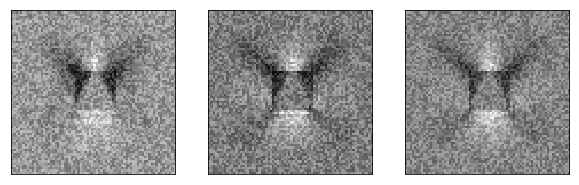

In [12]:
# for adam
fig, a = plt.subplots(1, 3, figsize = (10,6))
for i in range (3):
    a[i].imshow(model_2.get_weights()[0].T[i].reshape(72,72), extent=[-0.15,1.15,-0.15,1.15],cmap='gray' )
    a[i].set_xticks([])
    a[i].set_yticks([])

## A more difficult classification problem

### Linear Classifier

In [13]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True) # + 200 training
y_train = np_utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [14]:
model_2.compile(loss='categorical_crossentropy',optimizer=Adam_, metrics=['accuracy']) # Adam était le plus précis
model_2.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
500/500 [==============================] - 1s 2ms/step - loss: 5.9951 - acc: 0.3800
Epoch 2/30
500/500 [==============================] - 0s 175us/step - loss: 7.1993 - acc: 0.3020
Epoch 3/30
500/500 [==============================] - 0s 205us/step - loss: 4.8671 - acc: 0.3260
Epoch 4/30
500/500 [==============================] - 0s 184us/step - loss: 2.1823 - acc: 0.3920
Epoch 5/30
500/500 [==============================] - 0s 177us/step - loss: 2.1507 - acc: 0.3940
Epoch 6/30
500/500 [==============================] - 0s 188us/step - loss: 1.6663 - acc: 0.3700
Epoch 7/30
500/500 [==============================] - 0s 207us/step - loss: 1.4790 - acc: 0.4080
Epoch 8/30
500/500 [==============================] - 0s 183us/step - loss: 1.3692 - acc: 0.4260
Epoch 9/30
500/500 [==============================] - 0s 176us/step - loss: 1.3920 - acc: 0.4280
Epoch 10/30
500/500 [==============================] - 0s 184us/step - loss: 1.1589 - acc: 0.4540
Epoch 11/30
500/500 [==========

In [15]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [16]:
model_2.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 1ms/step


[0.9193982760111491, 0.5166666674613952]

### Convolutionnal classifier

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

X_train_bis = X_train.reshape(X_train.shape[0],72,72,1)
y_train = np_utils.to_categorical(Y_train, 3)
model_3 = Sequential()
model_3.add(Conv2D(16,(5,5), activation = 'relu', input_shape = (72,72,1)))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Conv2D(16,(5,5), activation = 'relu', input_shape = (72,72,1)))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(3,activation='softmax'))
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_3.fit(X_train_bis,y_train, epochs = 30, batch_size = 32)

Epoch 1/30
500/500 [==============================] - 5s 9ms/step - loss: 1.0881 - acc: 0.3860
Epoch 2/30
500/500 [==============================] - 4s 7ms/step - loss: 1.0280 - acc: 0.4980
Epoch 3/30
500/500 [==============================] - 3s 7ms/step - loss: 0.9120 - acc: 0.5620
Epoch 4/30
500/500 [==============================] - 3s 7ms/step - loss: 0.8042 - acc: 0.6260
Epoch 5/30
500/500 [==============================] - 3s 7ms/step - loss: 0.7237 - acc: 0.6460
Epoch 6/30
500/500 [==============================] - 3s 7ms/step - loss: 0.6821 - acc: 0.7020
Epoch 7/30
500/500 [==============================] - 3s 6ms/step - loss: 0.6028 - acc: 0.7540
Epoch 8/30
500/500 [==============================] - 3s 6ms/step - loss: 0.5429 - acc: 0.7780
Epoch 9/30
500/500 [==============================] - 3s 7ms/step - loss: 0.4578 - acc: 0.8440
Epoch 10/30
500/500 [==============================] - 3s 7ms/step - loss: 0.3950 - acc: 0.8720
Epoch 11/30
500/500 [============================

In [18]:
X_test_bis = X_test.reshape(X_test.shape[0],72,72,1)
model_3.evaluate(X_test_bis, Y_test)

300/300 [==============================] - 1s 4ms/step


[0.35683584372202554, 0.8866666666666667]

## A regression problem

In [19]:
[X_train, Y_train] = generate_dataset_regression(10000, 20)
# en raison de la difficulté du problème, on élargit grandement le training set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

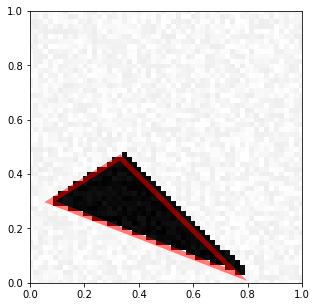

In [20]:
visualize_prediction(X_train[0], Y_train[0])

In [21]:
def normalize_Y(vertices):
    coordinates = []
    for i in range(3):
        coordinate = [vertices[2*i],vertices[2*i+1]]
        coordinates.append(coordinate)
    coordinates = sorted(coordinates, key=lambda elmt: elmt[0])
    return np.array([item for sublist in coordinates for item in sublist])


On entraine un réseau de neurones sur 50 epochs avec des batchs de 256.

In [23]:
X_train_shaped = X_train.reshape(len(X_train), 72, 72, 1)
model_4 = Sequential()
model_4.add(Conv2D(16,(5,5), activation = 'relu', input_shape = (72,72,1)))
model_4.add(MaxPooling2D(pool_size = (2,2)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(16,(5,5), activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))
model_4.add(Flatten())
model_4.add(Dense(6))
model_4.compile(loss = 'mean_squared_error', optimizer = 'adam')
model_4.fit(X_train_shaped, np.apply_along_axis(func1d=normalize_Y, axis=1, arr=Y_train), epochs = 50, batch_size = 256)

Epoch 1/50
10000/10000 [==============================] - 85s 8ms/step - loss: 0.1551
Epoch 2/50
10000/10000 [==============================] - 58s 6ms/step - loss: 0.0597
Epoch 3/50
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0374
Epoch 4/50
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0328
Epoch 5/50
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0310
Epoch 6/50
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0304
Epoch 7/50
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0297
Epoch 8/50
10000/10000 [==============================] - 58s 6ms/step - loss: 0.0291
Epoch 9/50
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0287
Epoch 10/50
10000/10000 [==============================] - 58s 6ms/step - loss: 0.0280
Epoch 11/50
10000/10000 [==============================] - 58s 6ms/step - loss: 0.0272
Epoch 12/50
10000/10000 [===========================

In [25]:
X_test = generate_dataset_regression(300, 20)[0]
X_test_shaped = X_test.reshape(len(X_test), 72, 72, 1)
predictions = model_4.predict(X_test_shaped)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


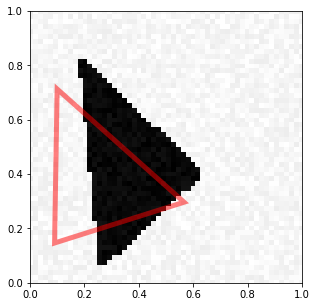

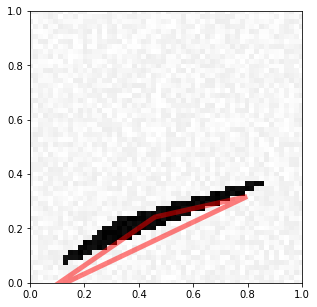

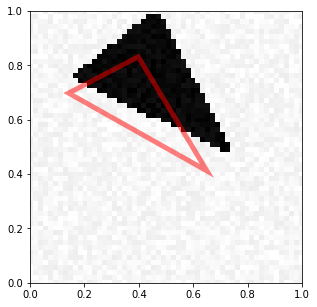

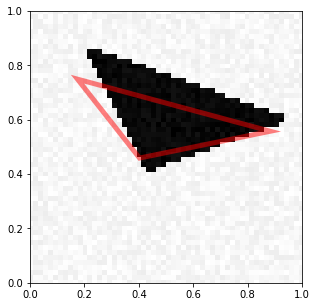

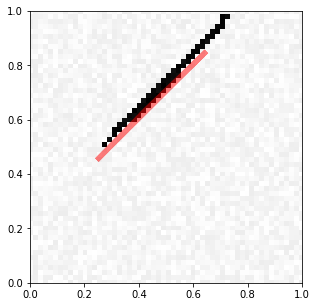

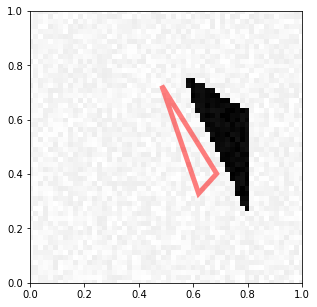

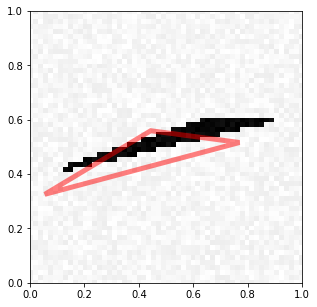

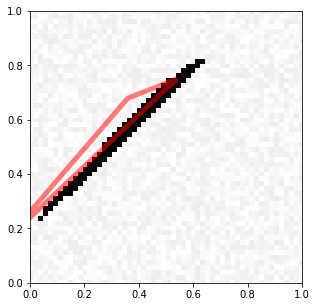

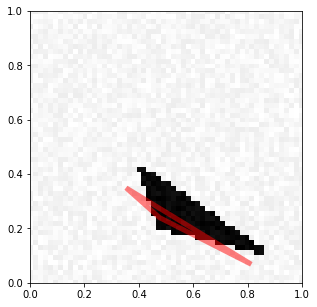

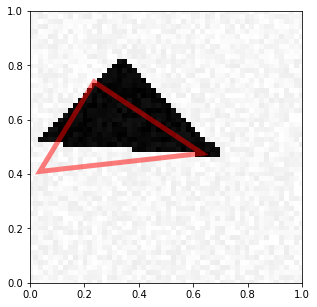

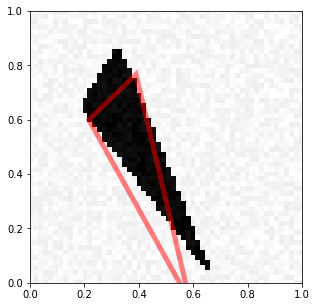

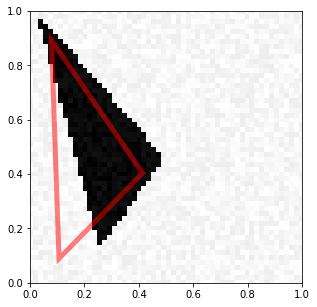

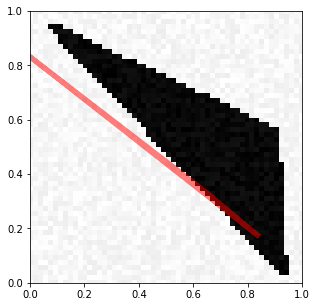

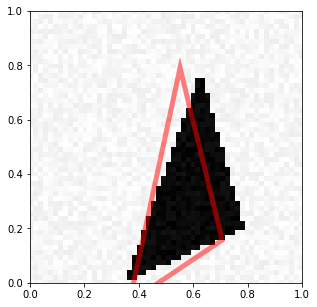

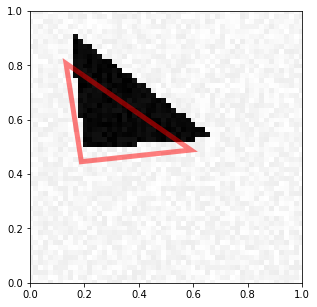

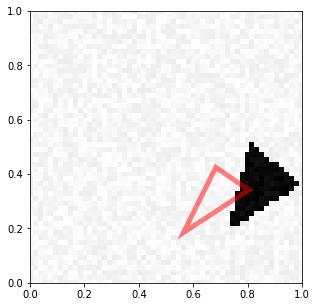

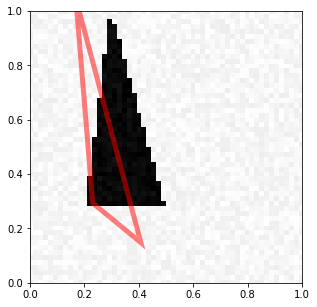

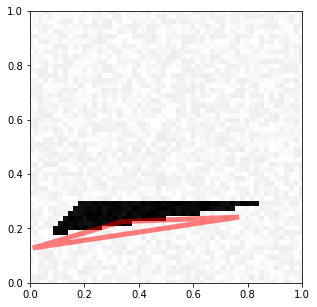

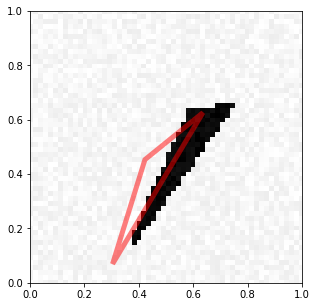

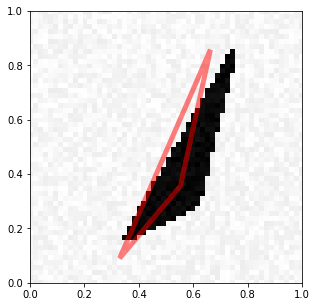

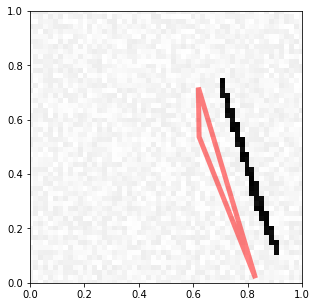

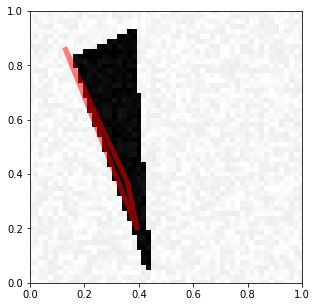

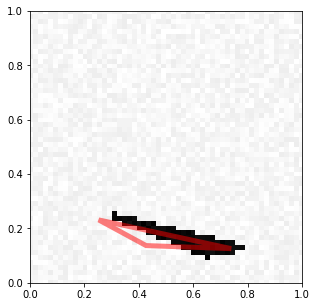

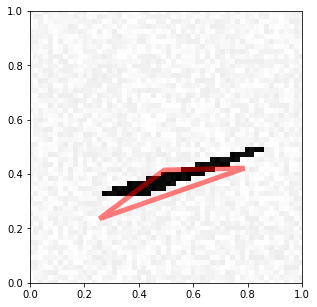

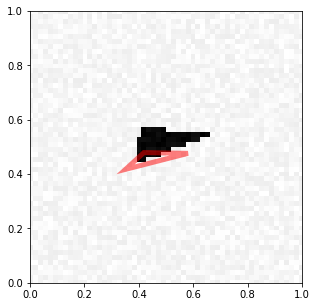

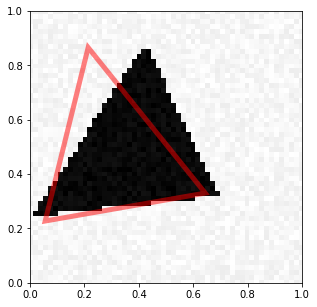

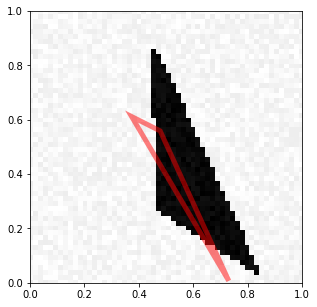

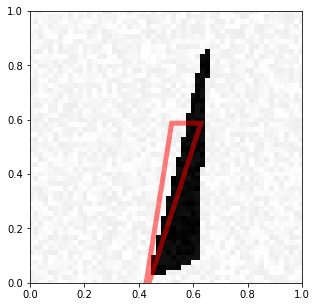

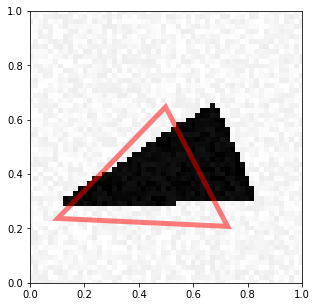

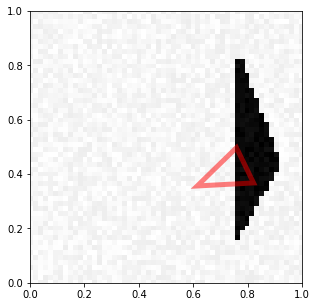

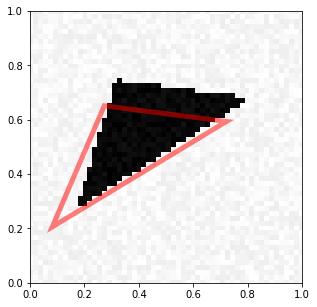

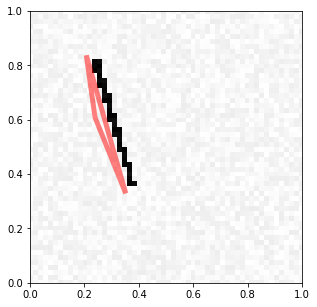

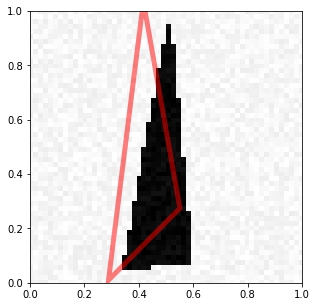

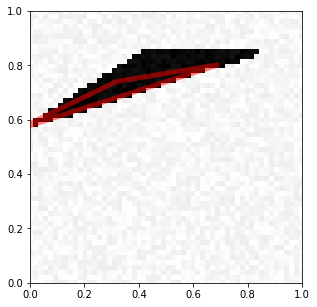

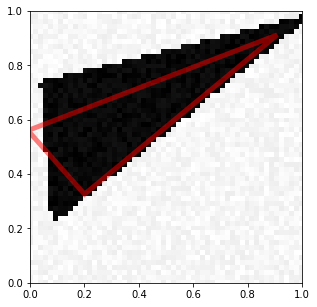

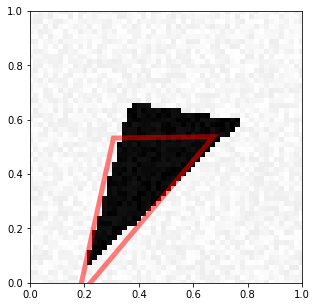

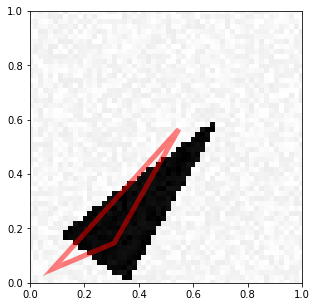

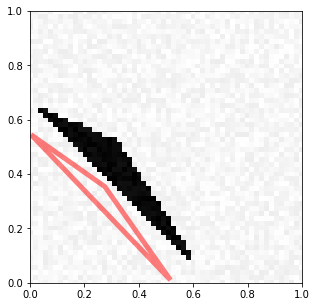

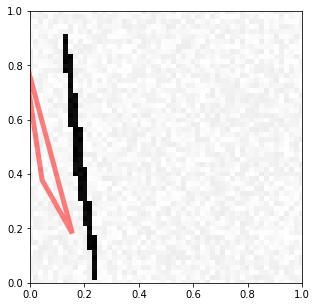

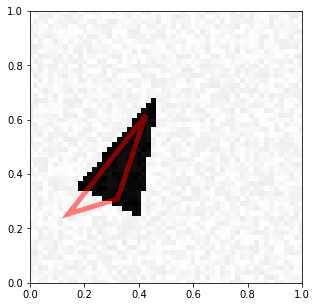

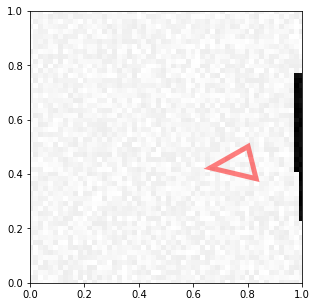

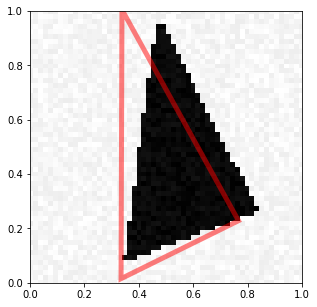

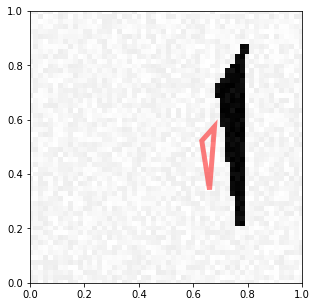

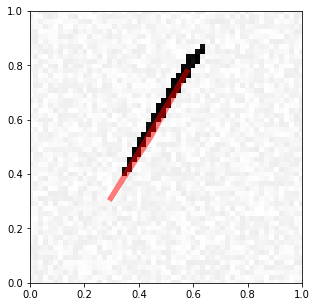

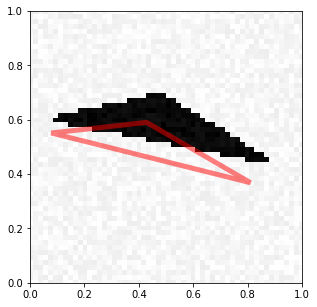

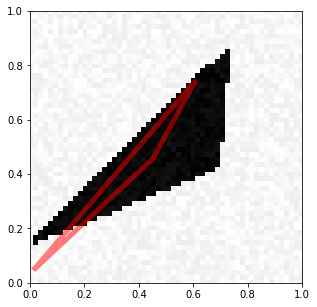

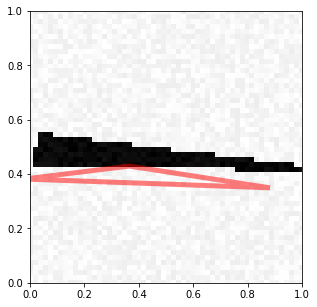

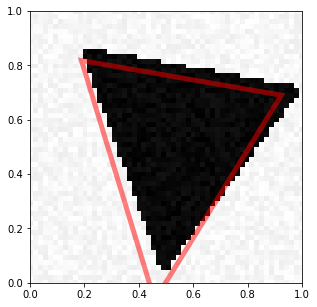

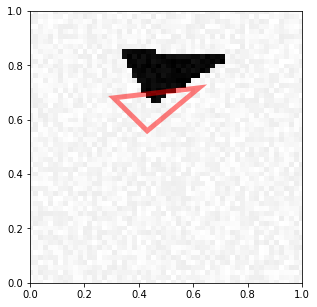

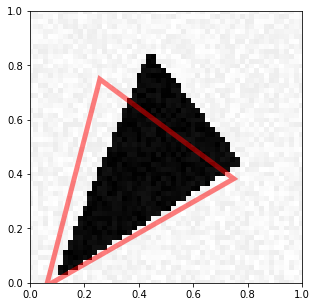

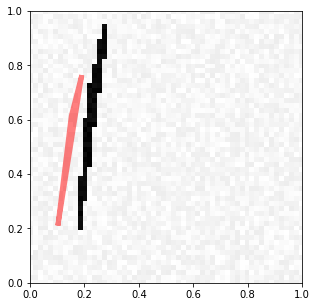

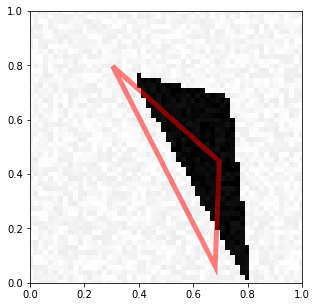

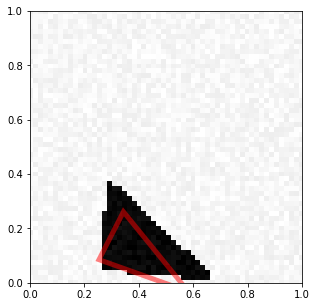

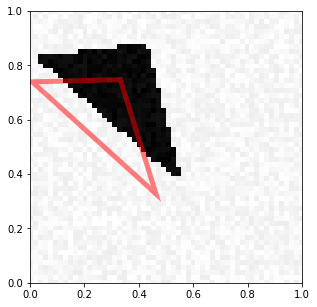

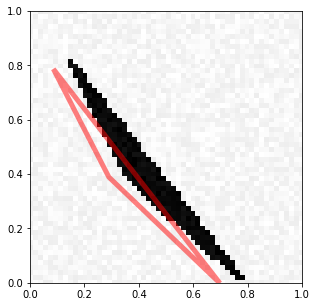

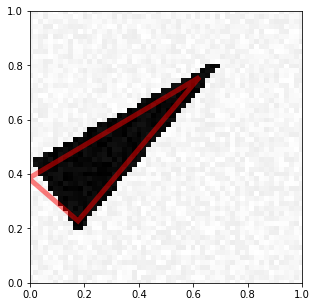

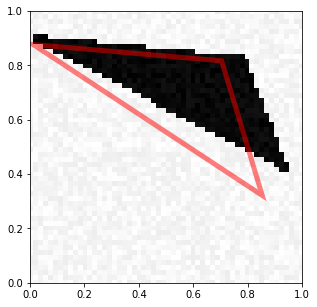

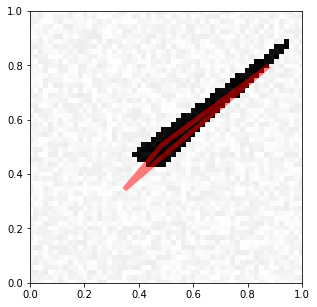

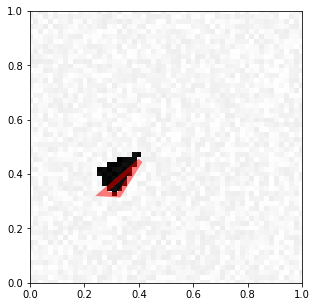

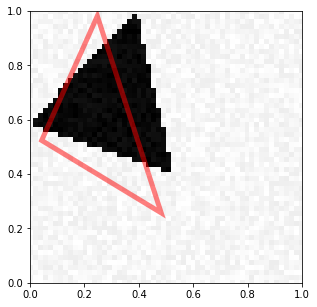

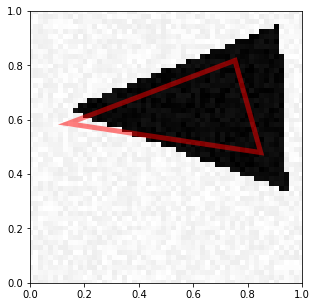

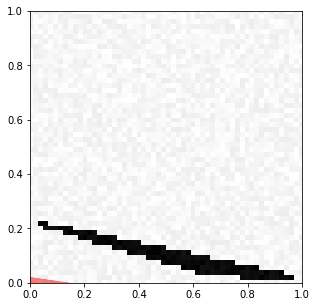

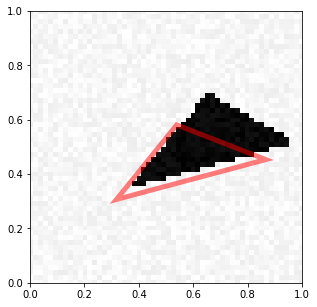

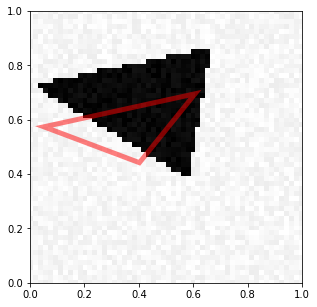

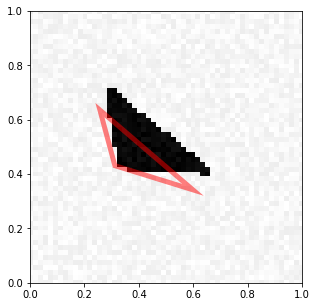

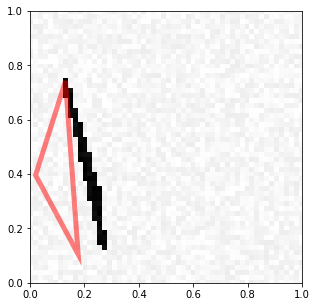

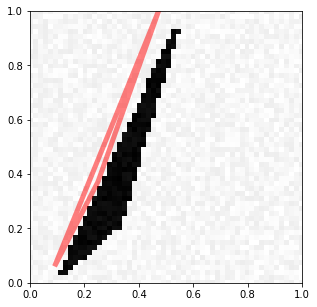

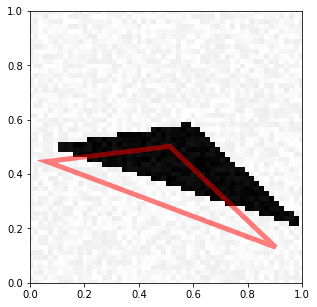

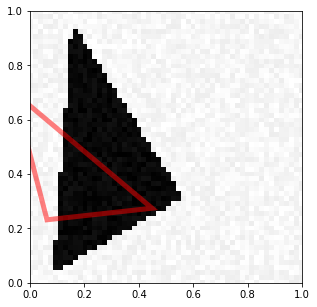

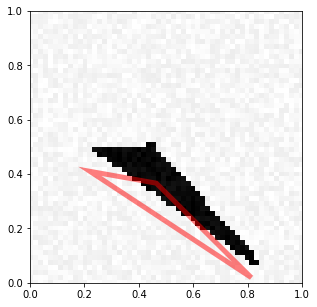

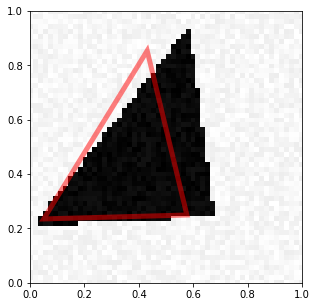

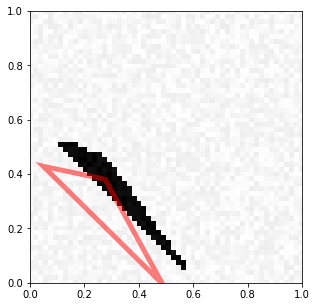

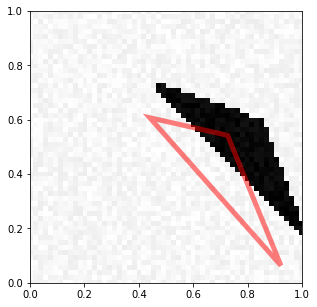

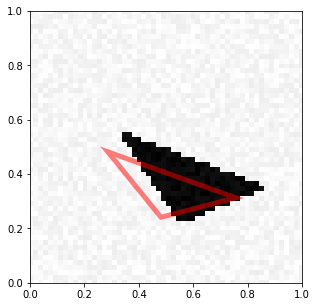

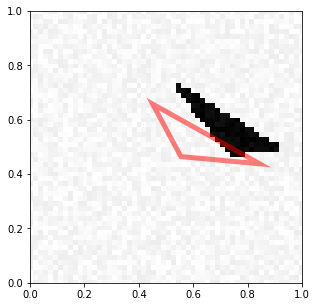

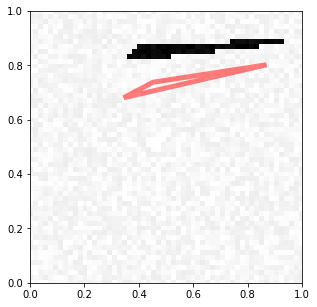

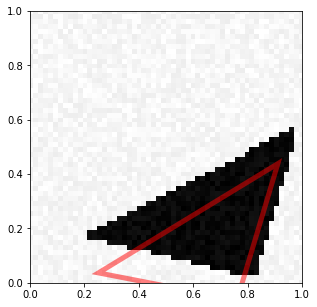

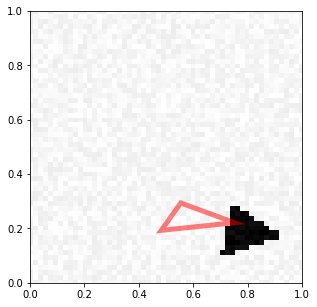

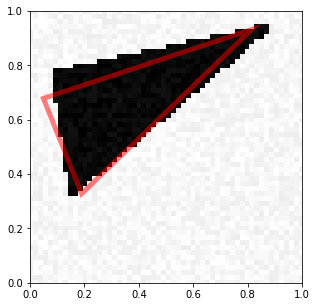

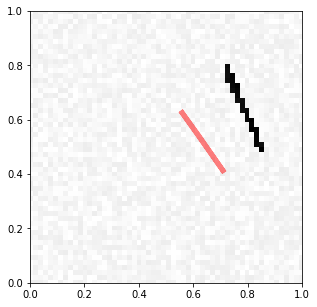

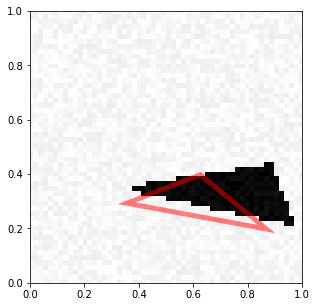

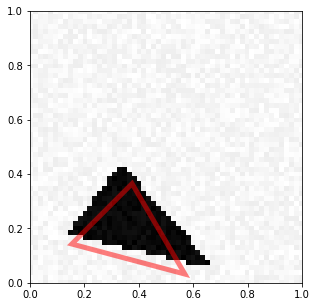

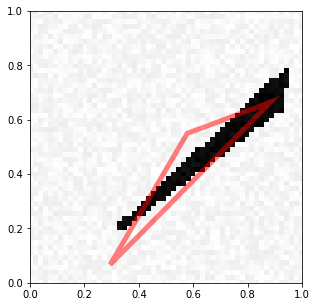

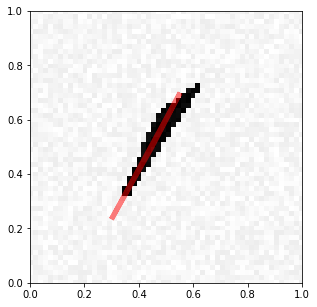

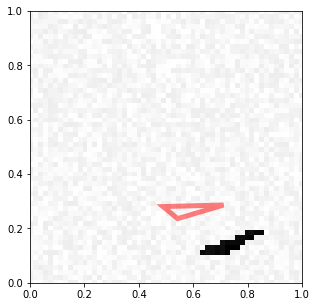

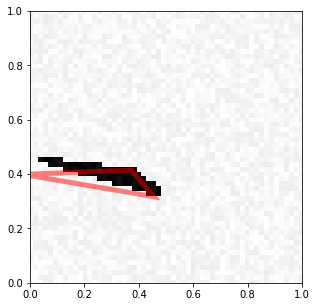

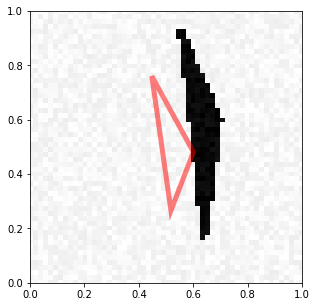

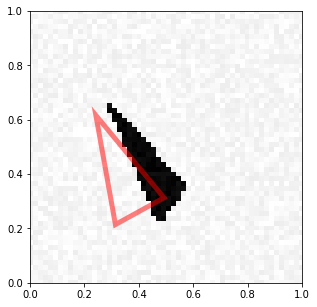

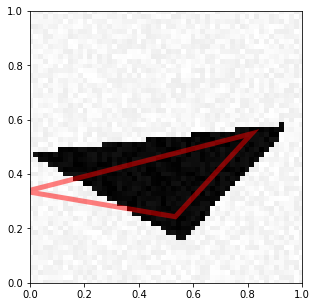

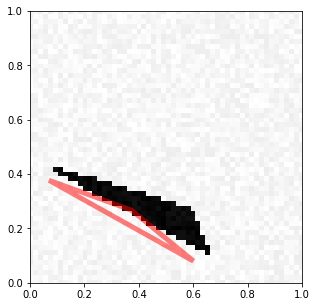

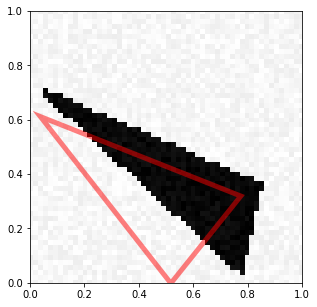

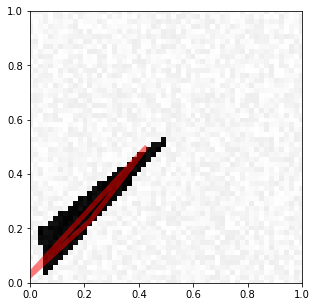

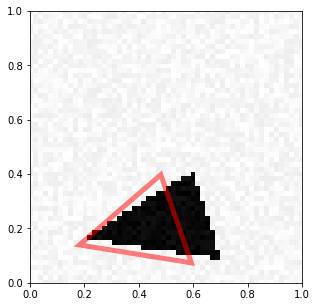

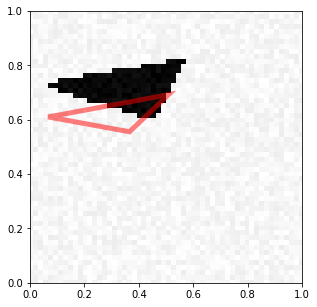

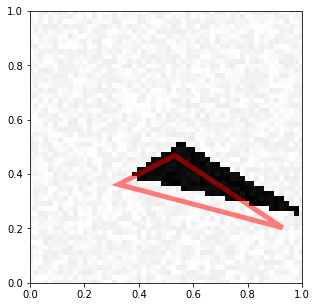

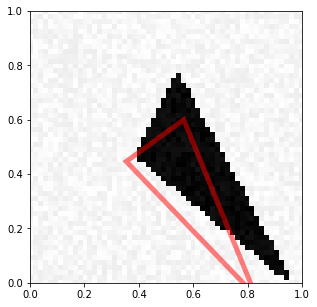

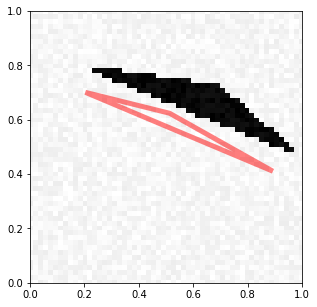

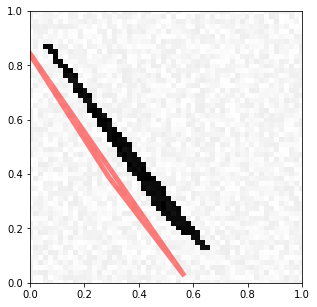

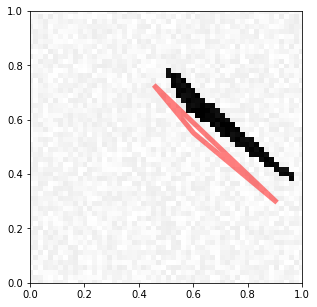

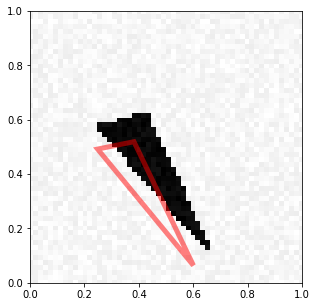

In [28]:
for i in range(100):
    visualize_prediction(X_test[i], predictions[i])

## Image Denoising

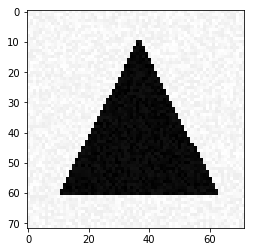

In [3]:
def generate_a_drawing(figsize, U, V, noise=1000):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noised = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return (imdata, imdata_noised) # renvoie une image "propre" et une image bruitée

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)[1]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)[1]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)[0][1], generate_a_triangle(20, False)[1]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [4]:
def generate_dataset_classification(nb_samples, noise=np.random.randint(100,500), free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            [[X[i], Y[i]], V] = generate_a_triangle(noise, free_location)
    X = X / 255
    Y = (Y + noise) / (255 + 2 * noise)
    return [Y, X] # afin de renvoyer successivement l'image bruitée et l'image "propre"

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, np.random.randint(100,500), True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [10]:
[X_train, Y_train] = generate_dataset_classification(1000)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


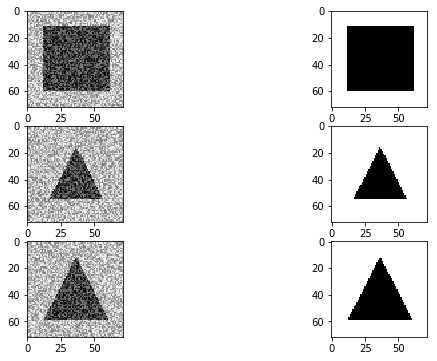

In [6]:
fig, a = plt.subplots(3,2, figsize = (10,6))
for i in range(3):
    a[i][0].imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    a[i][1].imshow(Y_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [43]:
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose

X_train_shaped = X_train.reshape(len(X_train), 72, 72, 1)
Y_train_shaped = Y_train.reshape(len(Y_train), 72, 72, 1)
model_5 = Sequential()
model_5.add(Conv2D(16, (3, 3), activation='relu', input_shape=(72, 72, 1), padding='same'))
print(model_5.output_shape)
model_5.add(MaxPooling2D(pool_size=(2, 2)))
print(model_5.output_shape)
model_5.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
print(model_5.output_shape)
model_5.add(UpSampling2D((2, 2)))
print(model_5.output_shape)
model_5.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
print(model_5.output_shape)

model_5.compile(loss = 'binary_crossentropy', optimizer = 'adam')
model_5.fit(X_train_shaped, Y_train_shaped, epochs = 100, batch_size = 32)

(None, 72, 72, 16)
(None, 36, 36, 16)
(None, 36, 36, 16)
(None, 72, 72, 16)
(None, 72, 72, 1)
Epoch 1/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5158
Epoch 2/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.4495
Epoch 3/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3680
Epoch 4/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1918
Epoch 5/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0659
Epoch 6/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0324
Epoch 7/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0224
Epoch 8/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0178
Epoch 9/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0152
Epoch 10/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0138
Epoch 11/100
1000/1000 [=====================

1000/1000 [==============================] - 10s 10ms/step - loss: 0.0061
Epoch 95/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0060
Epoch 96/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0059
Epoch 97/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0060
Epoch 98/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0059
Epoch 99/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0059
Epoch 100/100
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0059


In [44]:
[X_test, Y_test] = generate_dataset_classification(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [45]:
Y_predicted = model_5.predict(X_test.reshape(len(X_test), 72, 72, 1))

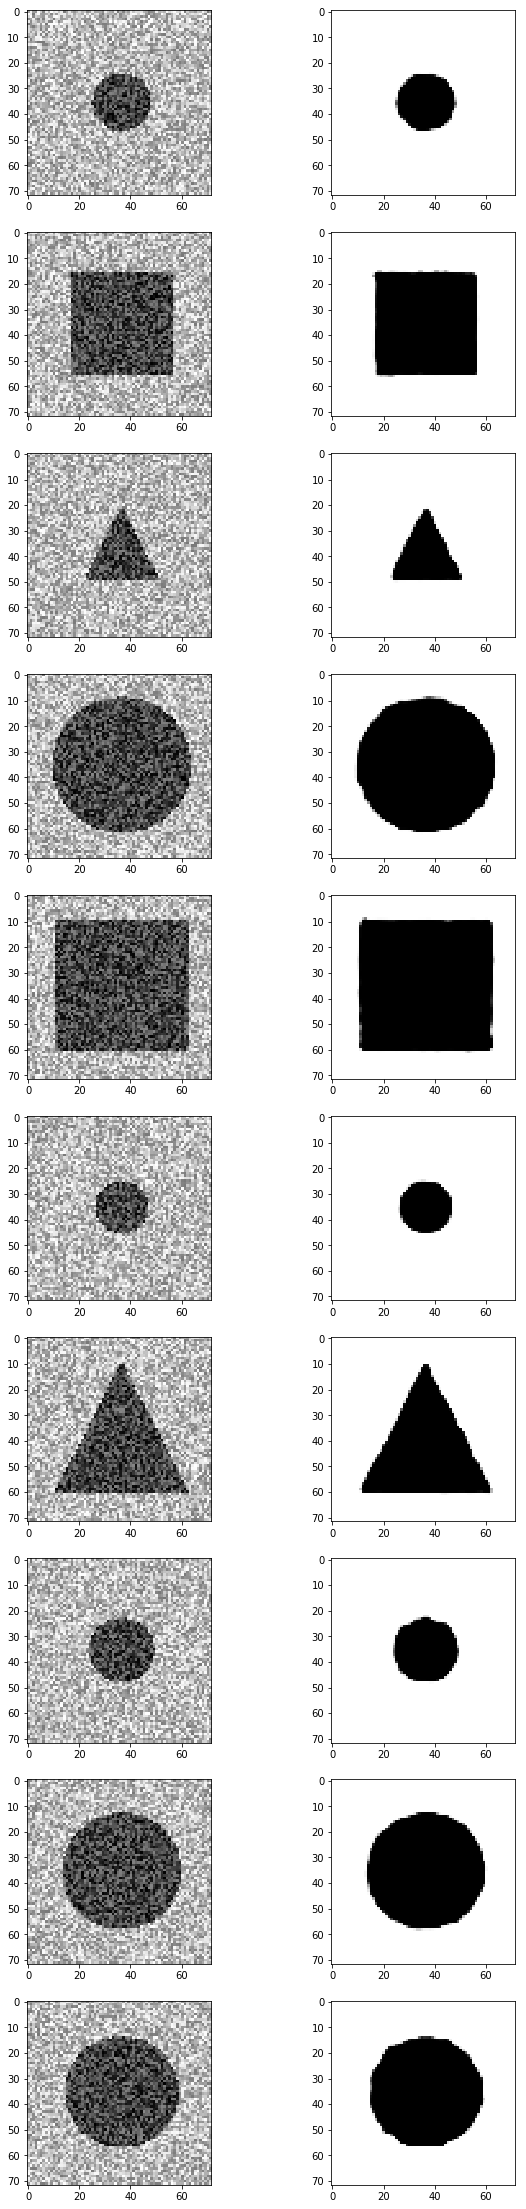

In [46]:
nrows = 10
fig, a = plt.subplots(nrows,2, figsize = (10,40))
for i in range(nrows):
    a[i][0].imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    a[i][1].imshow(Y_predicted[i].reshape(72,72), cmap='gray')